In [1]:
# code for the paper
# it is based on the github repository Freia https://github.com/VLL-HD/FrEIA

In [2]:
#inverse kinematics test
import torch
import numpy as np
%matplotlib notebook
from time import time
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
import random

torch.manual_seed(0)
np.random.seed(0)

no_samples = 100000
samples = np.random.binomial(size=no_samples, n=1, p= 0.5)
x1 = torch.zeros(no_samples,1)
for i in range(no_samples):
    if samples[i] == 0:
        x1[i]  = -1+ torch.randn(1,1)*(1/8)
    else: 
        x1[i]  = 1+ torch.randn(1,1)*(1/8)
x2  = torch.randn(no_samples,1)*0.5
x3  = torch.randn(no_samples,1)*0.5
x4  = torch.randn(no_samples,1)*0.5

# forward model
y1 = x1 + 0.5*torch.sin(x3-x2)+0.5*torch.sin(x2)+torch.sin(x4-x3-x2)
y2 = 0.5*torch.cos(x3-x2)+0.5*torch.cos(x2)+torch.cos(x4-x3-x2)

In [3]:
x_train = torch.cat((x1,x2,x3,x4),1)
y_train = torch.cat((y1,y2),1)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# use no padding
ndim_tot = 4
ndim_x = 4
ndim_y = 2
ndim_z = 2

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 256), nn.ReLU(),
                         nn.Linear(256, 256), nn.ReLU(),
                         nn.Linear(256,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(7):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp': 0.7},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False).to(device)

# number of gaussians to be used
no_gaussians = 2 



prob_net = nn.Sequential(nn.Linear(ndim_y,64), nn.ReLU(),nn.Linear(64,64), nn.ReLU(),
                        nn.Linear(64,no_gaussians), nn.Softmax(dim = 1)).to(device)

model.load_state_dict(torch.load('Gumbel_new.pt'))
prob_net.load_state_dict(torch.load('Gumbel_probs_new.pt'))


<All keys matched successfully>

In [5]:
n_epochs = 500
batch_size = 3200

y_noise_scale = 1e-2
zeros_noise_scale = 1e-4

lr_INN = 1e-3
lr_prob = 1e-3
l2_reg = 1e-5
Loss_ramp = True

# relative loss weights
lambd_predict = 65. #14
lambd_latent = 10.
lambd_rev = 21. 
lambd_recon = 10.

gum = torch.distributions.gumbel.Gumbel(torch.tensor([0.0]), torch.tensor([1.0]), validate_args=None)
temp = 0.1
no_gaussians = 2
# means of the GMM
means = torch.tensor([[-2.,0],[2.,0]], device = device)
# standard deviation of Gaussian
scale = 0.3


pad_x = torch.zeros(batch_size, ndim_tot - ndim_x)
pad_yz = torch.zeros(batch_size, ndim_tot - ndim_y - ndim_z)

trainable_parameters = [p for p in model.parameters() if p.requires_grad]

prob_par = [p for p in prob_net.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(trainable_parameters, lr=lr_INN, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)

optimizer2 = torch.optim.Adam(prob_par, lr=lr_prob) 


def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)




def MMD_matrix_multiscale(x, y, widths_exponents):
    xx, yy, xy = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = torch.clamp(rx.t() + rx - 2.*xx, 0, np.inf)
    dyy = torch.clamp(ry.t() + ry - 2.*yy, 0, np.inf)
    dxy = torch.clamp(rx.t() + ry - 2.*xy, 0, np.inf)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for C,a in widths_exponents:
        XX += C**a * ((C + dxx) / a)**-a
        YY += C**a * ((C + dyy) / a)**-a
        XY += C**a * ((C + dxy) / a)**-a

    return XX + YY - 2.*XY

def f(x):
    y1 = x[:,0] + 0.5*torch.sin(x[:,2]-x[:,1])+0.5*torch.sin(x[:,1])+torch.sin(x[:,3]-x[:,2]-x[:,1])
    y2 = 0.5*torch.cos(x[:,2]-x[:,1])+0.5*torch.cos(x[:,1])+torch.cos(x[:,3]-x[:,2]-x[:,1])
    y1 = y1.view(1,1)
    y2 = y2.view(1,1)
    return torch.cat((y1,y2),1)

def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_matrix_multiscale
loss_latent = MMD_matrix_multiscale
loss_fit = fit

In [6]:
def train(i_epoch=0):
    model.train()
    l_tot = 0
    t_start = time()
    
    # If MMD on x-space is present from the start, the model can get stuck.
    # Instead, ramp it up exponetially.
    if Loss_ramp:
        loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch) / n_epochs)))
    else:
        loss_factor = 1.
    perm = torch.randperm(len(x_train))
    perm = perm[:batch_size]
    x = x_train[perm]
    y = y_train[perm]
    x, y = x.to(device), y.to(device)
        

    optimizer.zero_grad()          
    optimizer2.zero_grad()

    #Pass and create data

    y_clean = y.clone()
    pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
    pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
    y = y + y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)
    
    # Gumbel trick for sampling z
    probs = prob_net(y)
    gumbs = gum.sample((len(y),no_gaussians)).to(device).view(len(y),no_gaussians)
    logits = gumbs+torch.log(probs)
    maxi,index = torch.max(logits, dim = 1)
    maxi = maxi.view(len(maxi),1)
    maxi = torch.cat((maxi,maxi),1)
    #logits = torch.exp(logits/temp)/torch.sum(torch.exp(logits/temp), dim = 1).view(len(y),1)
    logits = torch.exp((logits-maxi)/temp)/torch.sum(torch.exp((logits-maxi)/temp), dim = 1).view(len(y),1)
    # Create an array of all possible mixture components with all means
    norms = torch.zeros(len(y),no_gaussians,ndim_z,device = device)+means
    # Enlarge logits array to fit the size of norms
    logits2 = torch.cat((logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1)), dim = 2) 
    # linearly combinate the mixture components
    q = torch.sum(logits2*norms, dim = 1).view(len(y),ndim_z)
    # put it into z
    z = q+scale*torch.randn(len(y),ndim_z, device = device)

    # Pad vectors
    x, y = (torch.cat((x, pad_x),  dim=1),torch.cat((z, pad_yz, y),dim=1))

    # Forward step
    output = model(x)
    # Shorten output, and remove gradients wrt y, for latent loss
    y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)
    l = lambd_predict * loss_fit(output[:, -ndim_y:], y[:, -ndim_y:])
    output_block_grad = torch.cat((output[:, :ndim_z],
                                   output[:, -ndim_y:].data), dim=1)
    l += lambd_latent * torch.mean(loss_latent(output_block_grad, y_short,[(0.2, 2), (1.5, 2), (3.0, 2)]))

    l_tot += l.data.item()
    l.backward()

    # Backward step
    pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                             ndim_y - ndim_z, device=device)
    y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)
    probs = prob_net(y)
    gumbs = gum.sample((len(y),no_gaussians)).to(device).view(len(y),no_gaussians)
    logits = gumbs+torch.log(probs)
    maxi,index = torch.max(logits, dim = 1)
    maxi = maxi.view(len(maxi),1)
    maxi = torch.cat((maxi,maxi),1)
    #logits = torch.exp(logits/temp)/torch.sum(torch.exp(logits/temp), dim = 1).view(len(y),1)
    logits = torch.exp((logits-maxi)/temp)/torch.sum(torch.exp((logits-maxi)/temp), dim = 1).view(len(y),1)
    # Create an array of all possible mixture components with all means
    norms = torch.zeros(len(y),no_gaussians,ndim_z,device = device)+means
    # Enlarge logits array to fit the size of norms
    logits2 = torch.cat((logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1)), dim = 2) 
    # linearly combinate the mixture components
    q = torch.sum(logits2*norms, dim = 1).view(len(y),ndim_z)
    # put it into z
    z = q+scale*torch.randn(len(y),ndim_z, device = device)

    orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale * torch.randn(batch_size, ndim_z, device=device))
    y_rev = torch.cat((orig_z_perturbed, pad_yz,output.data[:, -ndim_y:] + y_noise_scale * torch.randn(batch_size, ndim_y, device=device) ), dim=1)
    output_rev = model(y_rev, rev=True)              
    y_rev_rand = torch.cat((z, pad_yz,y), dim=1)
    output_rev_rand = model(y_rev_rand, rev=True)

    l_rev = (lambd_rev * loss_factor * torch.mean(loss_backward(output_rev_rand[:, :ndim_x],x[:, :ndim_x],[(1.183, 0.2), (1.183, 1.0), (1.183, 2.0)])))

    l_rev += lambd_recon * loss_fit(output_rev, x)

    l_tot += l_rev.data.item()
    l_rev.backward()

    # Clamping and optimizer steps
    for p in model.parameters():
        p.grad.data.clamp_(-15.00, 15.00)

    for p in prob_net.parameters():
        p.grad.data.clamp_(-1.00, 1.00)
    optimizer.step()
    optimizer2.step()

   

    

    return l_tot


In [12]:
for i in range(n_epochs):
    train_loss = train(i)
    if i%100 ==0:
        print('TRAIN LOSS at epoch '+str(i)+': '+str(train_loss))

TRAIN LOSS at epoch 0: 149.78252068907022
TRAIN LOSS at epoch 100: 1.7776246815919876
TRAIN LOSS at epoch 200: 1.076352559030056
TRAIN LOSS at epoch 300: 1.073229804635048
TRAIN LOSS at epoch 400: 1.0332135409116745


In [15]:
#evaluation for second y
y = torch.zeros(100,2, device = device)
y[:,0] = 0.5
y[:,1] = 1.5
z = scale*torch.randn(100,2, device = device)

probs = prob_net(y.to(device))
print(probs[0])
for i in range(len(z)):
    num = random.random()
    if num < probs[i][0]:
        z[i] = z[i] + means[0]
    else: 
        z[i] = z[i] + means[1]     
inp = torch.cat((z, y),1).to(device)

out = model(inp, rev = True).cpu().detach().numpy()


pts = []
for i in range(len(out)):
    seq = np.zeros((4,2))
    seq[0][0] = out[i,0]
    seq[0][1] = 0
    seq[1][0] = out[i,0]+0.5*np.sin(out[i,1])
    seq[1][1] = 0.5*np.cos(out[i,1])
    seq[2][0] = out[i,0]+0.5*np.sin(out[i,1])+0.5*np.sin(out[i,2]-out[i,1])
    seq[2][1] = 0.5*np.cos(out[i,1])+0.5*np.cos(out[i,2]-out[i,1])
    seq[3][0] = out[i,0]+0.5*np.sin(out[i,1])+0.5*np.sin(out[i,2]-out[i,1])+np.sin(out[i,3]-out[i,2]-out[i,1])
    seq[3][1] = 0.5*np.cos(out[i,1])+0.5*np.cos(out[i,2]-out[i,1])+np.cos(out[i,3]-out[i,2]-out[i,1])
    pts.append(seq)
    

tensor([3.7448e-04, 9.9963e-01], device='cuda:0', grad_fn=<SelectBackward>)


<IPython.core.display.Javascript object>


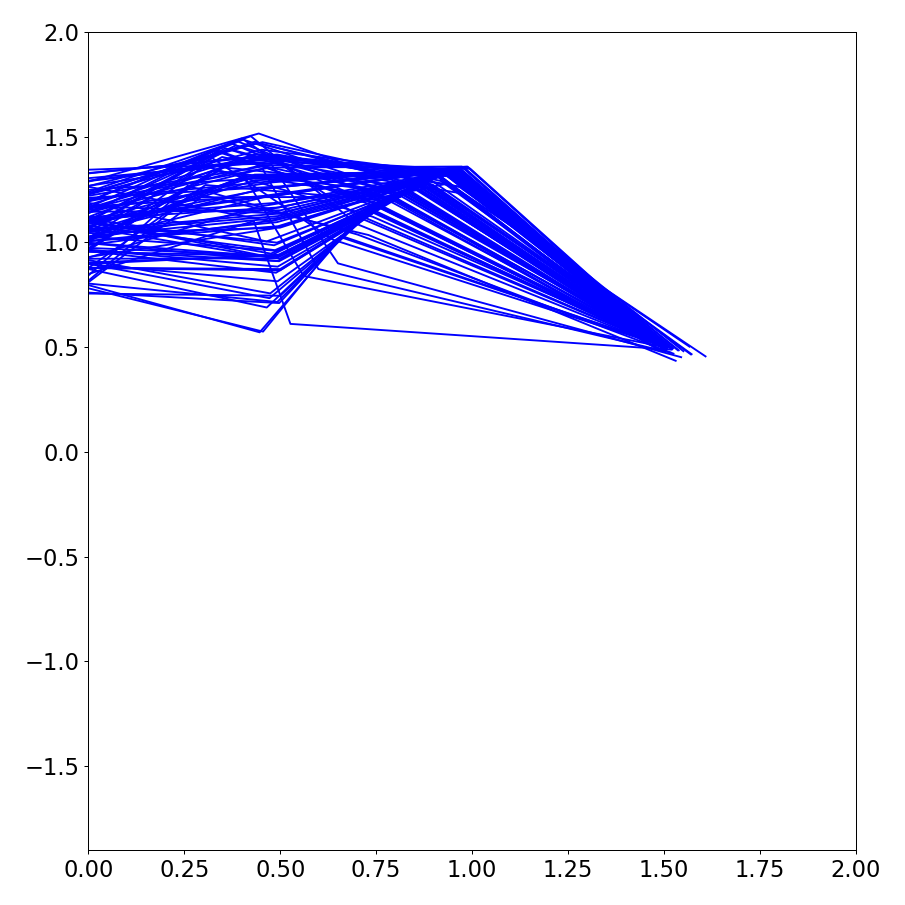

In [16]:
# visualization
fig = plt.figure(figsize=(10,10), dpi = 80)
for i in range(len(pts)):
    plt.plot(pts[i][:,1],pts[i][:,0], 'b')
plt.rcParams.update({'font.size': 18})
plt.ylim(-1.9, 2)
plt.xlim(0,2)
plt.show()
plt.tight_layout()
fig.savefig("gumbel_inn_2.png")

In [20]:
# evaluation for first y 
y = torch.zeros(100,2, device = device)
y[:,0] = 0.
y[:,1] = 1.5
z = scale*torch.randn(100,2, device = device)

probs = prob_net(y.to(device))
print(probs[0])
for i in range(len(z)):
    num = random.random()
    if num < probs[i][0]:
        z[i] = z[i] + means[0]
    else: 
        z[i] = z[i] + means[1]     
inp = torch.cat((z, y),1).to(device)

out = model(inp, rev = True).cpu().detach().numpy()


# test the error 
pts = []
for i in range(len(out)):
    seq = np.zeros((4,2))
    seq[0][0] = out[i,0]
    seq[0][1] = 0
    seq[1][0] = out[i,0]+0.5*np.sin(out[i,1])
    seq[1][1] = 0.5*np.cos(out[i,1])
    seq[2][0] = out[i,0]+0.5*np.sin(out[i,1])+0.5*np.sin(out[i,2]-out[i,1])
    seq[2][1] = 0.5*np.cos(out[i,1])+0.5*np.cos(out[i,2]-out[i,1])
    seq[3][0] = out[i,0]+0.5*np.sin(out[i,1])+0.5*np.sin(out[i,2]-out[i,1])+np.sin(out[i,3]-out[i,2]-out[i,1])
    seq[3][1] = 0.5*np.cos(out[i,1])+0.5*np.cos(out[i,2]-out[i,1])+np.cos(out[i,3]-out[i,2]-out[i,1])
    pts.append(seq)

tensor([0.4765, 0.5235], device='cuda:0', grad_fn=<SelectBackward>)


<IPython.core.display.Javascript object>


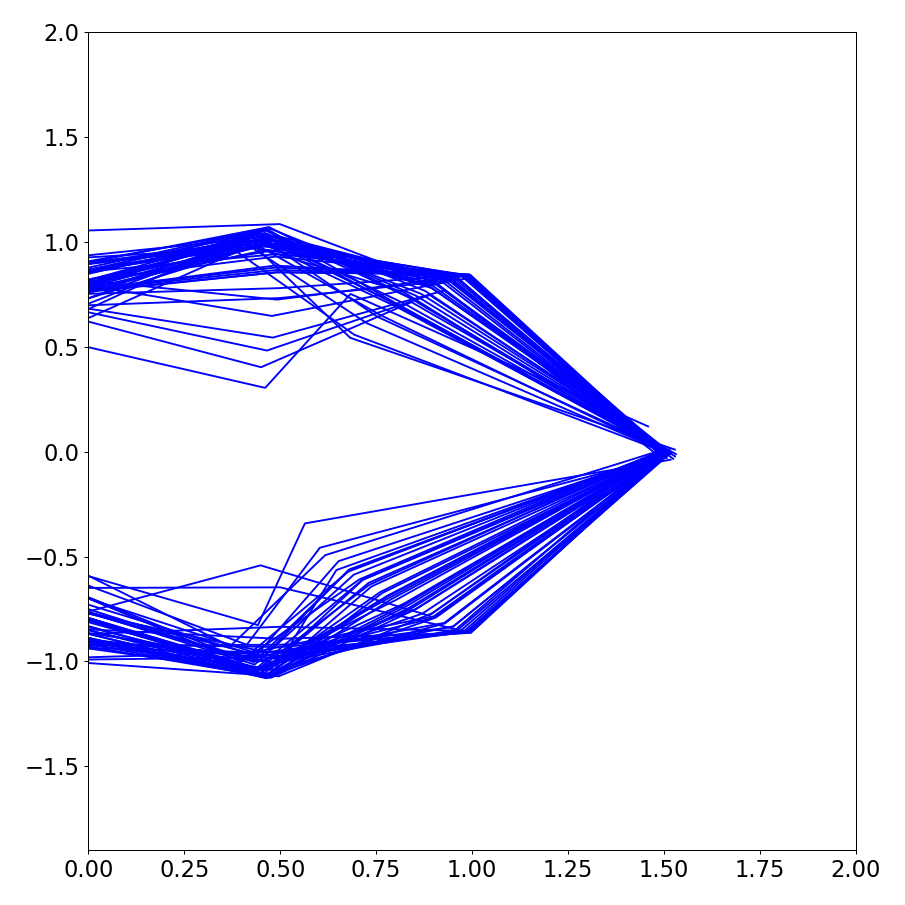

In [21]:
fig = plt.figure(figsize=(10,10), dpi = 80)
for i in range(len(pts)):
    plt.plot(pts[i][:,1],pts[i][:,0], 'b')
    
plt.rcParams.update({'font.size': 18})
plt.ylim(-1.9, 2)
plt.xlim(0,2)
plt.show()
plt.tight_layout()
fig.savefig("gumbel_inn_1.png")

In [19]:
n_epochs = 1800
temp = 0.1
batch_size = 3200
l2_reg = 1e-7

# relative weighting of losses:
lambd_predict = 150. 
lambd_latent = 10.
lambd_rev = 25. 

Loss_ramp = False
Sparsity_Reg = False



In [18]:
lrs = [8e-4,4e-4,1e-4,5e-5]
for lr in lrs:
    for g in optimizer.param_groups:
        g['lr'] = lr
        g['weight_decay'] = l2_reg 
        
    for g in optimizer2.param_groups:
        g['lr'] = lr
    for i in range(n_epochs):
        train_loss = train(i)
        if i%100 ==0:
            print('TRAIN LOSS at epoch '+str(i)+': '+str(train_loss))

TRAIN LOSS at epoch 0: 0.7927516102790833
TRAIN LOSS at epoch 100: 0.6919167339801788
TRAIN LOSS at epoch 200: 0.5305377691984177
TRAIN LOSS at epoch 300: 0.49208328127861023
TRAIN LOSS at epoch 400: 0.42663562297821045
TRAIN LOSS at epoch 500: 0.5193015038967133
TRAIN LOSS at epoch 600: 0.5188313126564026
TRAIN LOSS at epoch 700: 0.3949427008628845
TRAIN LOSS at epoch 800: 0.38634635508060455
TRAIN LOSS at epoch 900: 0.38714589178562164
TRAIN LOSS at epoch 1000: 0.44760435819625854
TRAIN LOSS at epoch 1100: 0.25338977575302124
TRAIN LOSS at epoch 1200: 0.3198899179697037
TRAIN LOSS at epoch 1300: 0.42168645560741425
TRAIN LOSS at epoch 1400: 0.33889319747686386
TRAIN LOSS at epoch 1500: 0.25674591213464737
TRAIN LOSS at epoch 1600: 0.5774786472320557
TRAIN LOSS at epoch 1700: 0.25535140186548233
TRAIN LOSS at epoch 0: 0.547962412238121
TRAIN LOSS at epoch 100: 0.22681249678134918
TRAIN LOSS at epoch 200: 0.22759319096803665
TRAIN LOSS at epoch 300: 0.22448937594890594
TRAIN LOSS at ep

In [12]:
tens = np.load('rejection_samples_multi.npy', allow_pickle = True)

y = torch.zeros(len(tens),2, device = device)
y[:,0] = 0.
y[:,1] = 1.5
z = scale*torch.randn(len(tens),2, device = device)
# update the means according to the probabilities
probs = prob_net(y.to(device))
for i in range(len(z)):
    num = random.random()
    if num < probs[0][0]:
        z[i] = z[i] + means[0]
    else: 
        z[i] = z[i] + means[1]     
inp = torch.cat((z,y),1).to(device)
out = model(inp, rev = True)

s = 0 
for j in range(len(out)):
    # resimulation error
    fx = f(out[j].view(1,4))[0]
    s += torch.sum((fx-torch.tensor([0.,1.5], device = device))**2)  
print(s/len(out))
    

tens = torch.tensor(tens).to(device).float()
print(MMD_multiscale(tens,out))

tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2834, device='cuda:0', grad_fn=<MeanBackward0>)


In [110]:
tens = np.load('rejection_samples_uni.npy', allow_pickle = True)

y = torch.zeros(len(tens),2, device = device)
y[:,0] = 0.5
y[:,1] = 1.5
z = scale*torch.randn(len(tens),2, device = device)
# update the means according to the probabilities
probs = prob_net(y.to(device))
for i in range(len(z)):
    num = random.random()
    if num < probs[0][0]:
        z[i] = z[i] + means[0]
    else: 
        z[i] = z[i] + means[1]     
inp = torch.cat((z,y),1).to(device)
out = model(inp, rev = True)

s = 0 
for j in range(len(out)):
    # resimulation error
    fx = f(out[j].view(1,4))[0]
    s += torch.sum((fx-torch.tensor([0.5,1.5], device = device))**2)  
print(s/len(out))

tens = torch.tensor(tens).to(device).float()

print(MMD_multiscale(tens,out))

tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0102, device='cuda:0', grad_fn=<MeanBackward0>)


In [18]:
torch.save(model.state_dict(), 'Gumbel_new.pt')
torch.save(prob_net.state_dict(), 'Gumbel_probs_new.pt')